In [1]:
!pip install opencv-python

### Importacion de bibliotecas generales

In [2]:
import os
import sys
import re

In [3]:
import pandas as pd
import numpy as np

In [4]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

### Importacion de librerias para armado y testeo de modelos

In [5]:
# operaciones sobre variables
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# normalizacion de variables
from sklearn.preprocessing import StandardScaler

### Variables globales

In [6]:
# path relativo al repositorio de imagenes
this_path = os.path.dirname('.')
rel_dataset_path = 'data/Covid19-dataset_completo/'

# path absoluto al repositorio de imagenes
abs_dataset_path = os.path.abspath(os.path.join(this_path, rel_dataset_path))

# path absoluto a dataset de training y a dataset testing
# photos1
photos1_dataset_path = os.path.join(abs_dataset_path, "photos1")
# photos2
photos2_dataset_path = os.path.join(abs_dataset_path, "photos2")
# photos3
photos3_dataset_path = os.path.join(abs_dataset_path, "photos3")

# expresion regular para buscar solamente imagenes
pat = '(jpeg|jpg|png)$'
reg = re.compile(pat, flags = re.IGNORECASE)

In [7]:
path_label = [path for path in os.listdir(photos1_dataset_path)]

In [8]:
print(path_label)

['Covid', 'Normal', 'Viral Pneumonia']


## Parametros de imagen ajustados

Analisis segun las siguientes condiciones:
    
    * dimesiones 100 x 100 (10000 pixeles).
    * en escala de grises

In [9]:
def new_dataset(dataset_path):
    '''
    creacion de nuevo dataset a partir de repositorio de imagenes
    dataset_path: ruta absoluta donde se encuentran las imagenes, test o train
    salida: tupla con:
        * matriz de dos dimensiones con mapa de bits de cada imagen (cada registro o lista de una dimension es una imagen) - Feature
        * lista de una dimension con valores numericos que representan la clase a la que pertenece la imagen - Target
        * lista de una dimension con las etiquetas de clase a la que pertenece cada imagen
    '''
    imgs_label = []
    imgs = []
    for pathlabel in os.listdir(dataset_path):
        label = os.path.join(dataset_path, pathlabel)
        for file in os.listdir(label):
            if re.search(pat, file) is not None:
                img = cv2.imread(os.path.join(label, file), cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100,100))
                img = img.flatten()
                imgs.append(img)
                imgs_label.append(pathlabel)
                
    label_to_id_dict = {v:i for i,v in enumerate(np.unique(imgs_label))}
    label_ids = np.array([label_to_id_dict[x] for x in imgs_label])
    
    return np.array(imgs), label_ids, np.array(imgs_label)

---

## Features y target como objetos de pandas

### Preparacion del dataset

Unificacion de set de train y testing para aplicar una estrategia de separacion a traves de los metodos de scikit learn. Se busca mantener la proporcionalidad de la clases de la variable target.

In [10]:
photos1_X, photos1_y, photos1_labels = new_dataset(photos1_dataset_path)
photos2_X, photos2_y, photos2_labels = new_dataset(photos2_dataset_path)
photos3_X, photos3_y, photos3_labels = new_dataset(photos3_dataset_path)

In [11]:
numpy_append = np.append(photos1_X, photos2_X, axis=0)
data_features = pd.DataFrame(np.append(numpy_append, photos3_X, axis=0))

In [12]:
data_features

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,203,187,180,169,171,167,161,163,159,154,...,97,101,119,86,79,63,31,13,9,7
1,0,0,0,0,0,0,0,0,0,0,...,231,228,228,216,210,212,202,192,168,125
2,7,8,8,8,7,7,7,6,6,5,...,36,28,2,2,5,8,10,11,12,30
3,169,169,167,171,173,169,154,56,18,68,...,140,132,128,120,102,95,92,81,78,70
4,143,144,144,144,144,148,10,3,3,4,...,29,28,24,21,18,18,14,14,14,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,5,5,4,5,4,4,2,0,0,0,...,14,0,0,0,0,0,0,0,0,0
666,45,42,39,36,32,24,18,19,27,43,...,18,14,42,44,46,22,20,20,21,21
667,0,0,0,0,0,0,7,17,32,51,...,121,94,32,9,0,0,0,0,0,0
668,0,0,0,6,13,50,68,81,92,94,...,185,181,134,105,51,0,0,0,0,0


In [13]:
numpy_append = np.append(photos1_y, photos2_y, axis=0)
data_target = pd.Series(np.append(numpy_append, photos3_y, axis=0))

In [14]:
data_features.shape, data_target.shape

((670, 10000), (670,))

**Armado de sets de test y train**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, stratify=data_target, random_state=0)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((502, 10000), (168, 10000), (502,), (168,))

In [21]:
y_train.value_counts(normalize=True)

1    0.344622
0    0.342629
2    0.312749
dtype: float64

In [22]:
y_test.value_counts(normalize=True)

1    0.345238
0    0.339286
2    0.315476
dtype: float64

---

**Estandarizamos**

Utilizamos sklearn para standarizar la matriz de Features

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Training**

Instanciemos y entrenemos uno modelo naive bayes gaussiano.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [42]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

**Predict**

Usemos el modelo entrenado en el ejercicio 2 para predecir la etiqueta de los datos de test

In [43]:
Y_pred = gnb.predict(X_test)

Y_pred

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 2, 0, 2, 0, 1,
       1, 0, 0, 2, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 2, 0, 1, 0, 0, 0, 2, 1,
       1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 2,
       1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 2, 2,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 1,
       2, 0, 0, 1, 2, 2, 1, 2, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0,
       0, 0, 2, 1, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 1, 0, 0, 2, 2, 1, 2, 0, 2, 0, 1, 1])

Calculemos la matriz de confusión sobre los datos de test y grafiquemos el heatmap de esta matriz.

In [45]:
# Obtenemos la matriz de confusión
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)
cm

array([[51,  5,  1],
       [ 1, 46, 11],
       [ 2,  5, 46]], dtype=int64)

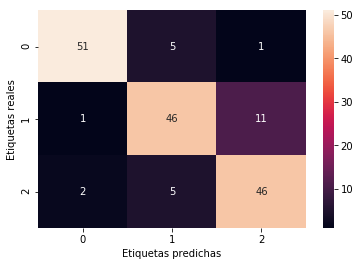

In [38]:
# Graficamos la matriz de confusión para visualizarla mejor
sns.heatmap(cm, annot=True)
plt.ylabel('Etiquetas reales')
plt.xlabel('Etiquetas predichas');

**Interpretacion de la matriz de confusión:**

Recordemos:
* 0 - Corresponde a los enfermos con COVID
* 1 - Corresponde a los pacientes saludables
* 2 - Corresponde a los enfermos con Neumonía

Siendo los casos positivos los que 'pacientes sanos'.  El mayor riesgo corresponde al falso positivo donde se predijo que estaba sano mientras estaba enfermo.


**Evaluación del modelo**

Asigamos variable a la matriz de confusión

In [50]:
TP = cm [2, 2]  # hemos predicho correctamente que el paciente está sano
TN = cm [0, 0]+cm [2, 2] # hemos predicho correctamente que el paciente está enfermo
FP = cm [0, 1]+cm [2, 1]+cm [0, 2] # hemos predicho que le paciente esta sano pero esta enfermo o confundido la enfermedad
FN = cm [1, 0]+cm [1, 2]+cm [2, 0] # hemos predicho que le paciente esta enfermo pero esta sano o confundido la enfermedad

**Accuracy**

(TP + TN) / (TP + TN + FP + FN)

In [63]:
from sklearn.metrics import accuracy_score
print('Accuracy=', accuracy_score(y_test, Y_pred).round(2)*100,'%')

Accuracy= 85.0 %


*Conclusión:*  el 85% (aprox.) de los casos —en el test set— han sido clasificados correctamente.

**Sensitivity (o recall)**

TP / TP + FN

In [93]:

recall = (TP / (TP + FN))
print('recall=', (TP / (TP + FN)).round(2)*100,'%')

recall= 77.0 %


*Conclusión:*  nuestro modelo está teniendo un alto rendimiento para detectar pacientes sanos en relación a las que realmente estan sanos.

**Specificity**

TN / (TN + FP)

In [70]:
print('Specificity=', (TN / (TN + FP)).round(2)*100,'%')

Specificity= 90.0 %


*Conclusión:*  nuesto modelo es muy específico, cometió pocos errores de falsos positivos (es decir que pocas veces dijo que un paciente estaba sano, cuando en realidad estaba enfermo).

**Precision**

TP / (TP + FP)

In [92]:
Precision = (TP / (TP + FP))
print('Precision=', (TP / (TP + FP)).round(2)*100,'%')


Precision= 81.0 %


*Conclusión:*  Que nuestro modelo es muy preciso. De cada 100 predicciones positivas que realiza el modelo (es decir, predice que un paciente este sano), acierta 81.

**False positive rate (FPR)**

(1 - Specificity)

In [79]:
print('FPR=', 100-((TN / (TN + FP))).round(2)*100,'%')

FPR= 10.0 %


### **Conclusión:**  OJO!! Parece que el indicar es bajo, pero por el caso de negocio se está arriesgando un 10% de vidas.  En el 10% de los casos los clasifica como sanos cuando estan enfermos.

**F1-Score**

2*(precision * Recall) / precision + Recall

In [98]:
print ('F1-Score=', 2*((Precision * recall) / (Precision + recall)).round(2)*100,'%')

F1-Score= 78.0 %


*Conclusión:*  alto valor de f1_score.  Es decir, es bueno identificando las clases positivas, y preciso.  Aunque por el caso de negocio NO lo suficente